# Making malls

## Local stores

In [1]:
from dol import JsonFiles, wrap_kvs, mk_dirs_if_missing, temp_dir, KeyPath, KeyTemplate, filt_iter, Files
import os

pjoin = os.path.join

In [2]:
# temporary directory

rootdir = temp_dir('ragdag/rjsf_fiddle')

print(rootdir)

/var/folders/mc/c070wfh51kxd9lft8dl74q1r0000gn/T/ragdag/rjsf_fiddle


In [4]:
## Making a key template

from dol import KeyTemplate
import os

pjoin = os.path.join

user_template = pjoin('u', '{user_name}')
stores_template = pjoin('stores', '{store_name}')

kt = KeyTemplate(template=pjoin(user_template, stores_template))
key_wrap = kt.key_codec(decoded='tuple', encoded='str')

back = {
    'u/bob/stores/spec_1': {'an': 'apple'},
    'u/bob/stores/spec_2': {'an': 'orange'},
    'u/alice/stores/spec_1': {'i_like': 'to move it'},
    'some/thing/else': 'contents'
}

front = key_wrap(kt.filt_iter(back))
assert sorted(front) == [('alice', 'spec_1'), ('bob', 'spec_1'), ('bob', 'spec_2')]
front['bob', 'spec_1']


{'an': 'apple'}

In [7]:
from raglab.stores.stores_util import *

def test_mk_local_user_store(verbose=False):

    rootdir = temp_dir('ragdag/rjsf_fiddle')
    if verbose:
        print(f"{rootdir=}")

    s = mk_local_user_store(rootdir, user_name='bob', store_kind='spec_1')
    s['some_key'] = b'some_value'
    s['some_other_key'] = b'some_other_value'
    if verbose:
        print(f"Go check out this folder: file://{s.rootdir}")
    assert 'some_key' in s
    assert s['some_key'] == b'some_value'
    assert 'some_key' in os.listdir(s.rootdir)

def test_mk_specialized_local_user_store(verbose=False):

    rootdir = temp_dir('ragdag/rjsf_fiddle')
    if verbose:
        print(f"{rootdir=}")

    s = mk_json_store(rootdir, user_name='alice', store_kind='jsons')
    s['some_key'] = {'a': 'b'}
    assert s['some_key'] == {'a': 'b'}

    # see that the file is there, with a json extension
    assert 'some_key.json' in os.listdir(s.rootdir)
    # see that the file contains the expected content, as json string
    from pathlib import Path
    assert Path(os.path.join(s.rootdir, 'some_key.json')).read_text() == '{"a": "b"}'

    s = mk_text_store(rootdir, user_name='alice', store_kind='texts')
    s['some_key'] = 'some_value'
    assert s['some_key'] == 'some_value'

    s = mk_pickle_store(rootdir, user_name='alice', store_kind='pickles')
    ecclectic_data = [1, 2.3, 'four']
    s['some_key'] = ecclectic_data
    assert s['some_key'] == ecclectic_data

test_mk_local_user_store(verbose=True)
test_mk_specialized_local_user_store()


rootdir='/var/folders/mc/c070wfh51kxd9lft8dl74q1r0000gn/T/ragdag/rjsf_fiddle'
Go check out this folder: file:///var/folders/mc/c070wfh51kxd9lft8dl74q1r0000gn/T/ragdag/rjsf_fiddle/u/bob/stores/spec_1/


# Little scrap demo with TN

In [ ]:
from functools import partial


In [22]:
def divide(x, y):
    return x / y

divide_2 = partial(divide, y=2)

divide_2(10)

num_fixed_division = partial(divide, 2)
num_fixed_division(10)



0.2

In [25]:
verbose = True

rootdir = temp_dir('ragdag/rjsf_fiddle')
if verbose:
    print(f"{rootdir=}")

s = mk_json_store(rootdir, user_name='alice', store_kind='jsons')

s['some_key'] = {'a': 'b'}
assert s['some_key'] == {'a': 'b'}
s['nicholas'] = {'my_stuff': [1,2,3]}

# # see that the file is there, with a json extension
# assert 'some_key.json' in os.listdir(s.rootdir)
# # see that the file contains the expected content, as json string
# from pathlib import Path

# assert Path(os.path.join(s.rootdir, 'some_key.json')).read_text() == '{"a": "b"}'

# s = mk_text_store(rootdir, user_name='alice', store_kind='texts')
# s['some_key'] = 'some_value'
# assert s['some_key'] == 'some_value'

# s = mk_pickle_store(rootdir, user_name='alice', store_kind='pickles')
# ecclectic_data = [1, 2.3, 'four']
# s['some_key'] = ecclectic_data
# assert s['some_key'] == ecclectic_data


rootdir='/var/folders/mc/c070wfh51kxd9lft8dl74q1r0000gn/T/ragdag/rjsf_fiddle'


In [30]:
f = '/private/var/folders/mc/c070wfh51kxd9lft8dl74q1r0000gn/T/ragdag/rjsf_fiddle/u/alice/stores/'

from dol import Files

t = Files(f)

list(t)



['jsons/some_key.json',
 'jsons/nicholas.json',
 'pickles/some_key.pkl',
 'texts/some_key.txt']

In [31]:
from dol import filt_iter

t = filt_iter(t, filt=lambda x: x.endswith('.json'))
list(t)

['jsons/some_key.json', 'jsons/nicholas.json']

In [34]:
t['jsons/nicholas.json']

b'{"my_stuff": [1, 2, 3]}'

In [32]:
key_of_id=lambda id_: id_[len('jsons/'):-len('.json')]
key_of_id('jsons/some_key.json')


'some_key'

In [33]:
# Key codec (transformation)
from dol import wrap_kvs

tt = wrap_kvs(
    t, 
    key_of_id=lambda id_: id_[len('jsons/'):-len('.json')],
    id_of_key=lambda key: f'jsons/{key}.json'
)

list(tt)

['some_key', 'nicholas']

In [35]:
tt['nicholas']

b'{"my_stuff": [1, 2, 3]}'

In [36]:
# Value codec (transformation)
import json 

ttt = wrap_kvs(
    tt,
    obj_of_data=lambda data: json.loads(data),
)

ttt['nicholas']

{'my_stuff': [1, 2, 3]}

In [40]:
import pandas as pd
import io

tttt = wrap_kvs(tt,
    obj_of_data=lambda data: pd.read_json(io.BytesIO(data)),
)

tttt['nicholas']

,my_stuff
0,1
1,2
2,3


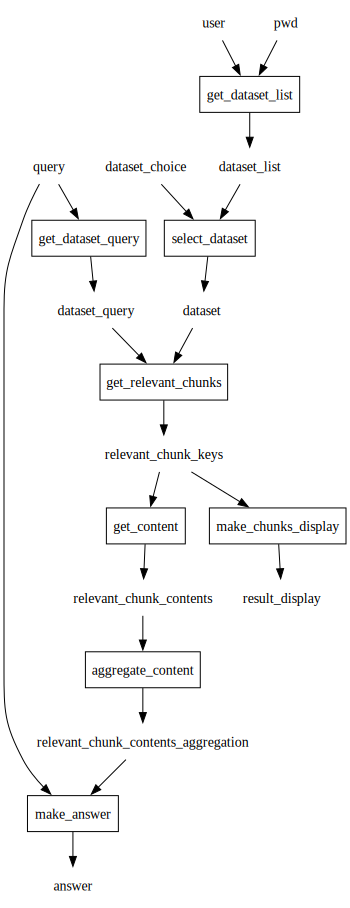

In [41]:
from meshed import code_to_dag

@code_to_dag
def rag_dashboard():
    dataset_list = get_dataset_list(user, pwd)
    dataset = select_dataset(dataset_list, dataset_choice)
    dataset_query = get_dataset_query(query)
    relevant_chunk_keys = get_relevant_chunks(dataset_query, dataset)
    result_display = make_chunks_display(relevant_chunk_keys)
    relevant_chunk_contents = get_content(relevant_chunk_keys)
    relevant_chunk_contents_aggregation = aggregate_content(relevant_chunk_contents)
    answer = make_answer(query, relevant_chunk_contents_aggregation)

rag_dashboard.dot_digraph()

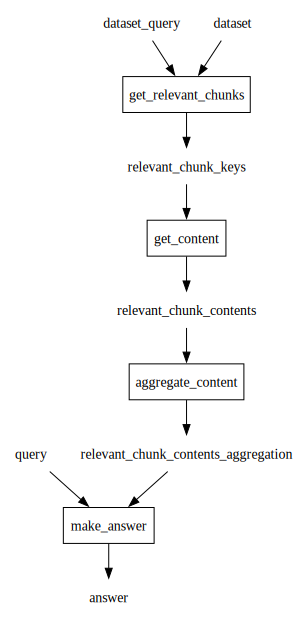

In [45]:
rag_dashboard['get_relevant_chunks':'answer'].dot_digraph()

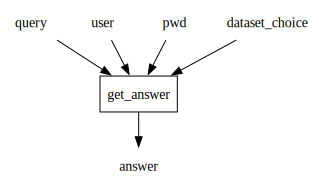

In [43]:
@code_to_dag
def easy():
    answer = get_answer(query, user, pwd, dataset_choice)

easy.dot_digraph()

In [43]:
list(s)
s['some_key']

b'some_value'

In [44]:
s = JsonFiles(rootdir)
list(s)

[]

In [24]:
s['asdf.json'] = {'a': 'b'}
list(s)

['asdf', 'some_key', 'Nonesome_key.json', 'asdf.json']

In [29]:
w = KeyCodecs.affixed(prefix='', suffix='.json')
ss = w({'a.json': {'a': 'b'}})
list(ss)

['a']

# Example of store explorer

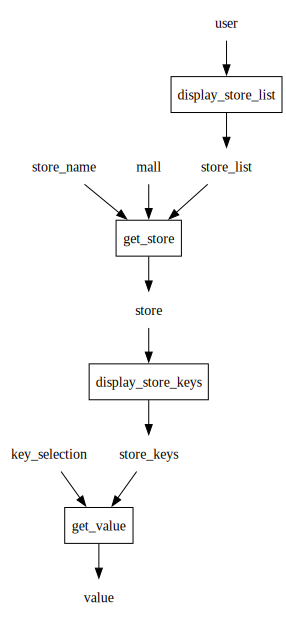

In [11]:
from meshed import code_to_dag

mall = {
    'forms': {'a': 1, 'b': 2},
    'images': {'dog': 'pic of dog'},
    'app': {'fiddle': 2, 'image_editing': 3}
}

@code_to_dag
def store_explorer():
    store_list = display_store_list(user)
    store = get_store(store_list, store_name, mall)
    store_keys = display_store_keys(store)
    value = get_value(store_keys, key_selection)

store_explorer.dot_digraph()
    



In [ ]:
...?user=USER&store=STORE_NAME&op=list

u/USER/s/STORE_NAME/list


...?user=USER&store=STORE_NAME&op=get_value&key=KEY

u/USER/s/STORE_NAME/get_value?key=KEY


function list_keys(store, user) {}

function get_value_for_key(store, user, key) {}
